In [2]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

# Draw an isochrone map with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

How far can you travel on foot in 15 minutes?

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [2]:
from graph_builder import GraphBuilder
# configure the place, network type, trip times, and travel speed


place = "Buenos Aires, Argentina"
network_type = "walk"

trip_times = [5, 10, 15, 30, 45, 60, 90]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

graph_builder = GraphBuilder(place, network_type, travel_speed)

## Download and prep the street network

In [4]:
# download the street network
graph_builder.initialize_graph()

In [5]:
# find the centermost node and then project the graph to UTM
center_node = graph_builder.calculate_centroid()
G = graph_builder.initialize_projected_graph()

## Plots nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [3]:
# get one color for each isochrone
from isochrone_plots import IsochronePlots
isochrone_plots = IsochronePlots(trip_times)

iso_colors = isochrone_plots.colors()

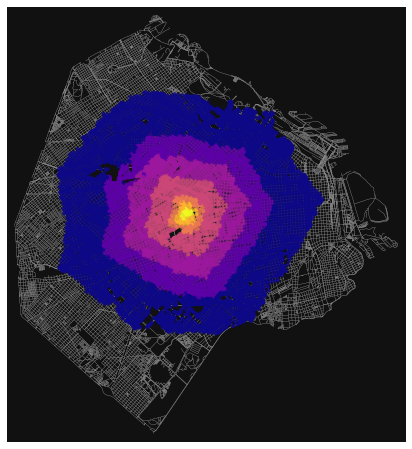

In [6]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [21]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

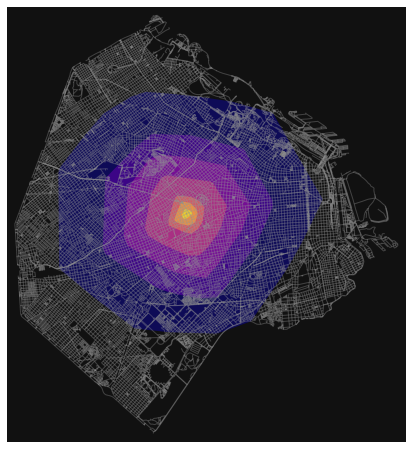

In [22]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()